In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col=['date'], 
                    parse_dates=['date'],
                    date_format="%d.%m.%Y")

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2935849 entries, 2013-01-02 to 2015-10-03
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   shop_id       int64  
 1   item_id       int64  
 2   item_price    float64
 3   item_cnt_day  float64
dtypes: float64(2), int64(2)
memory usage: 112.0 MB


In [4]:
sales = sales.sort_index()
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()
sales['time'] = arr

In [5]:
sales.head()

,shop_id,item_id,item_price,item_cnt_day,time
date,,,,,
2013-01-01,18,5823,2500.0,1.0,0
2013-01-01,27,5573,849.0,1.0,0
2013-01-01,7,1006,399.0,1.0,0
2013-01-01,19,17707,899.0,1.0,0
2013-01-01,14,19548,149.0,1.0,0


In [6]:
date_shop_sum = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
date_shop_count = sales.groupby(['date','shop_id']).nunique()[['item_id']]
date_shop_mean = sales.groupby(['date','shop_id']).mean()[['item_price']]
date_shop_median = sales.groupby(['date','shop_id']).median()[['time']]
sales_ = pd.concat([date_shop_sum, date_shop_count, date_shop_mean, date_shop_median], axis=1)

In [7]:
sales_ = sales_.reset_index()
sales_.index = sales_['date']

In [8]:
sales_.drop('date', inplace=True, axis=1)

In [9]:
sales_

,shop_id,item_cnt_day,item_id,item_price,time
date,,,,,
2013-01-01,2,24.0,23,1360.304348,0.0
2013-01-01,7,89.0,87,673.505747,0.0
2013-01-01,8,50.0,48,898.291667,0.0
2013-01-01,13,31.0,28,207.285714,0.0
2013-01-01,14,66.0,60,727.883333,0.0
...,...,...,...,...,...
2015-10-31,55,137.0,49,780.979592,1033.0
2015-10-31,56,67.0,61,797.081967,1033.0
2015-10-31,57,121.0,110,955.181818,1033.0


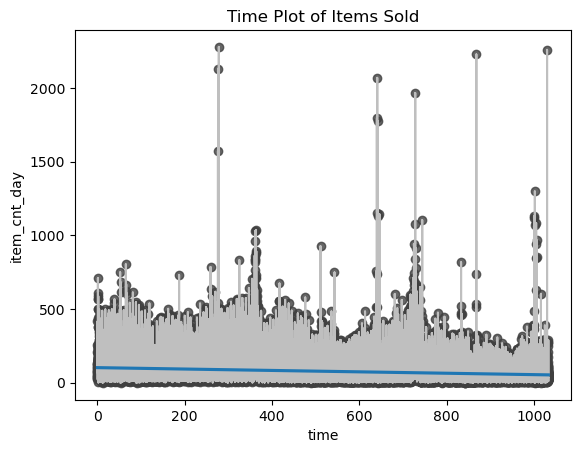

In [10]:
fig, ax = plt.subplots()
ax.plot('time', 'item_cnt_day', data=sales_, color='0.75')
ax = sns.regplot(x='time', y='item_cnt_day', data=sales_, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Items Sold');

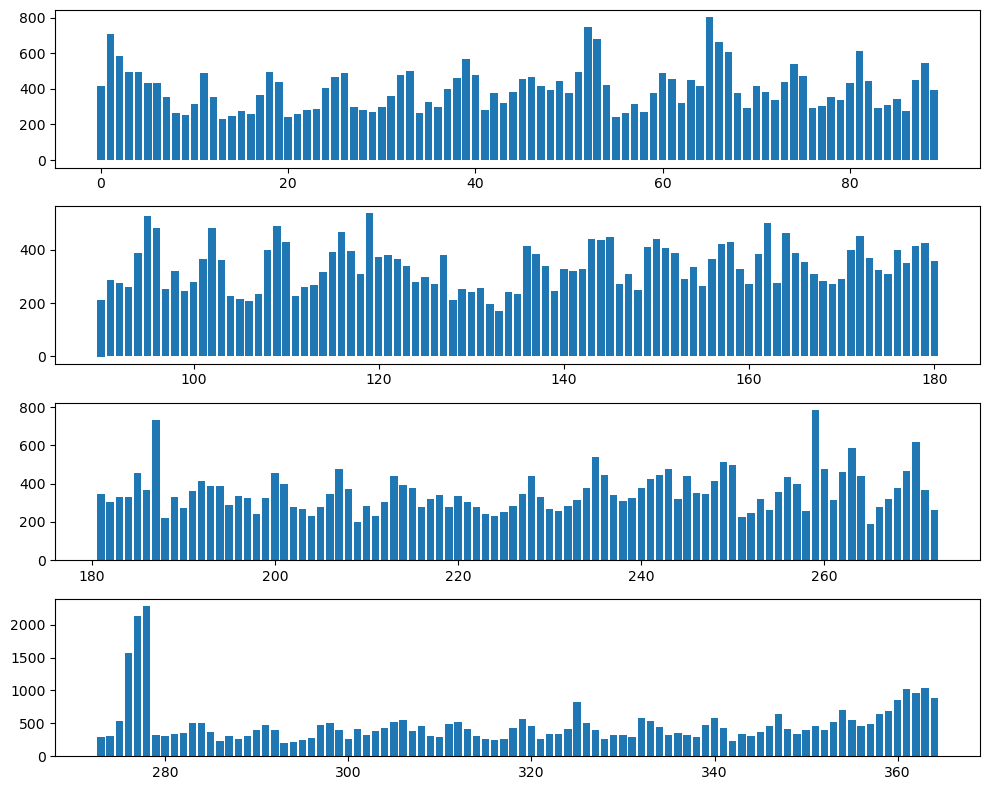

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,8))
ax1.bar('time','item_cnt_day', data=sales_.loc['2013-1-1':'2013-3-31',:])
ax2.bar('time','item_cnt_day', data=sales_.loc['2013-4-1':'2013-6-30',:])
ax3.bar('time','item_cnt_day', data=sales_.loc['2013-7-1':'2013-9-30',:])
ax4.bar('time','item_cnt_day', data=sales_.loc['2013-10-1':'2013-12-31',:])
fig.tight_layout()

In [41]:
for i in range(31):
    sales_[f'lag_{i+1}'] = sales_['item_cnt_day'].shift(i+1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13764\145498150.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


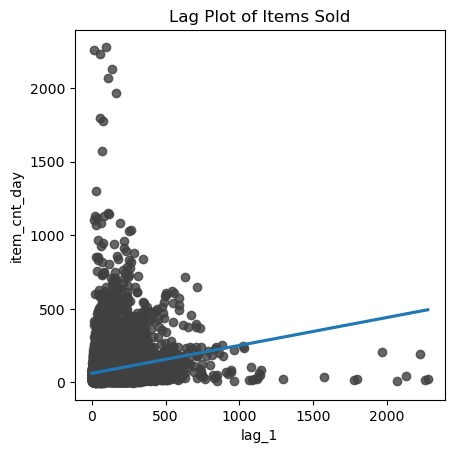

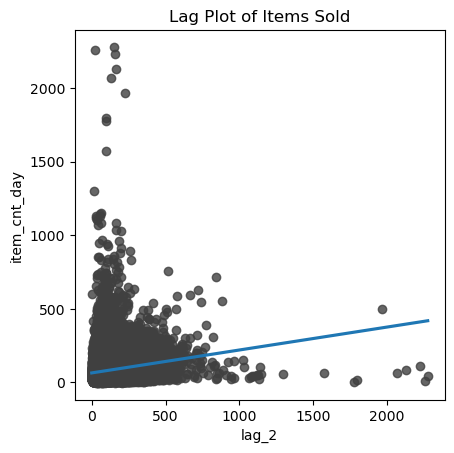

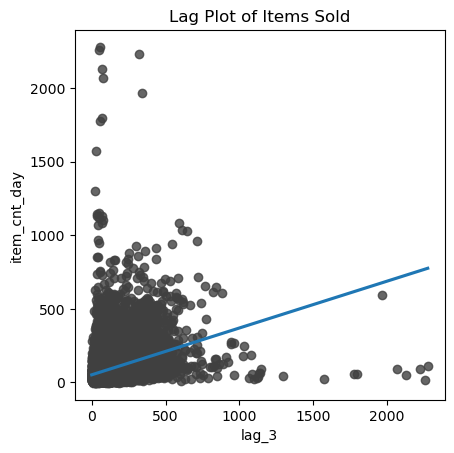

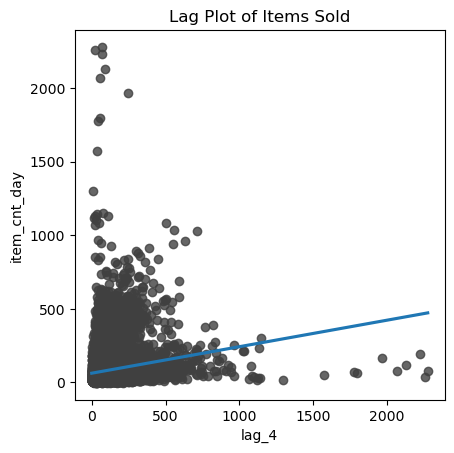

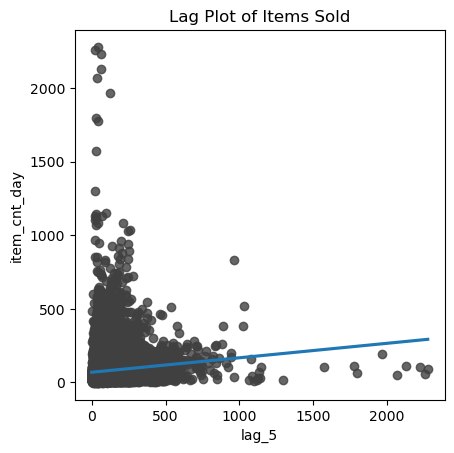

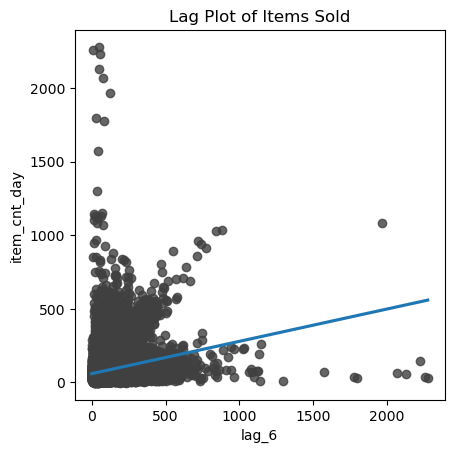

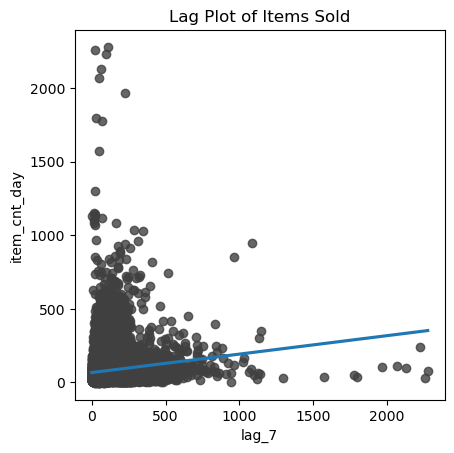

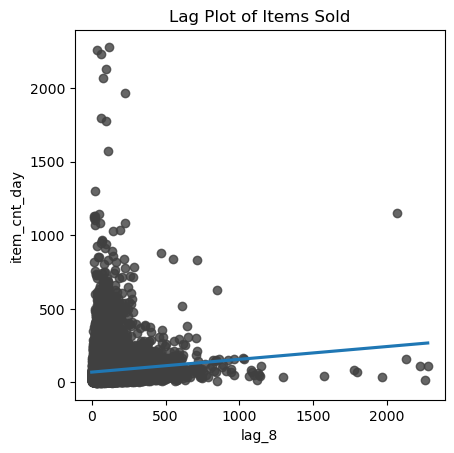

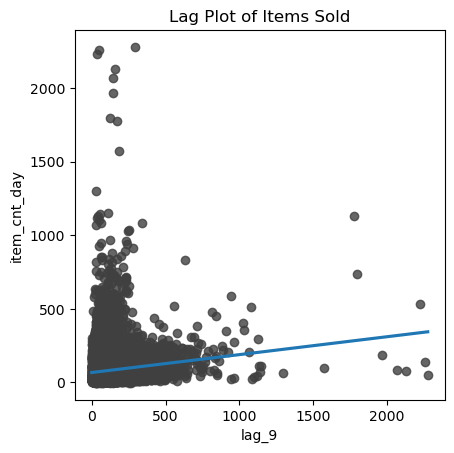

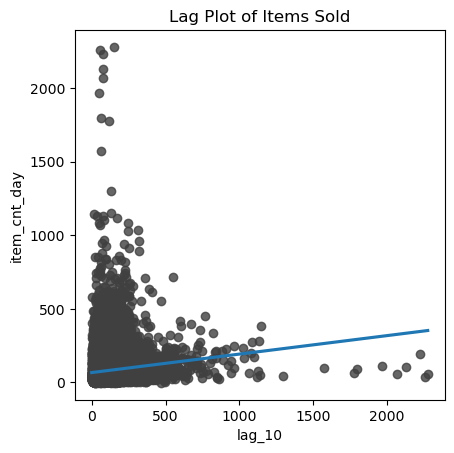

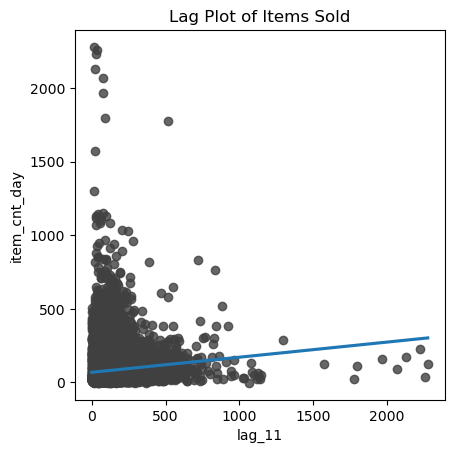

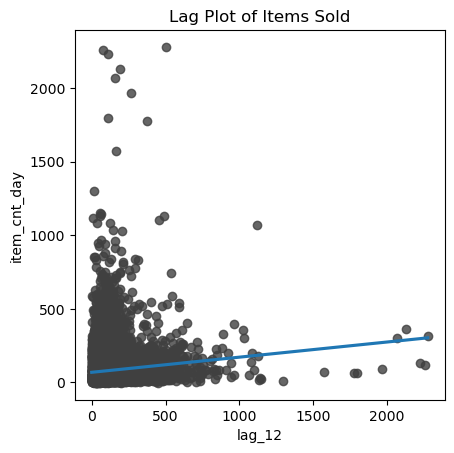

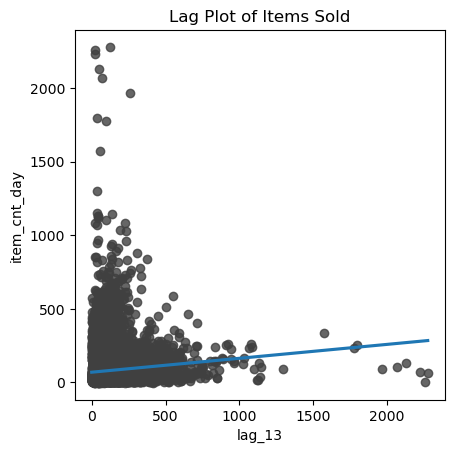

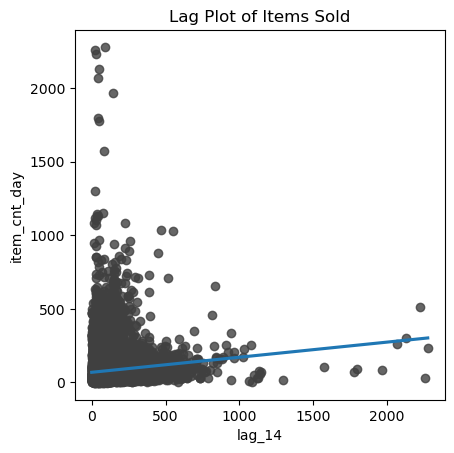

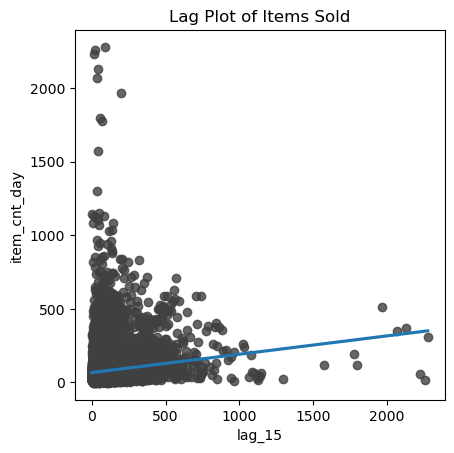

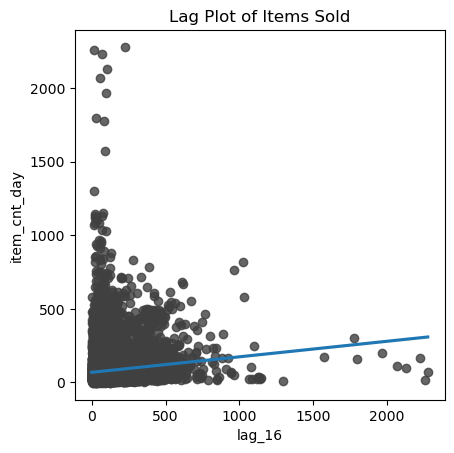

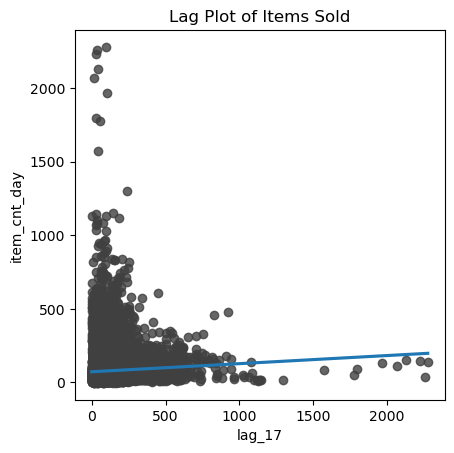

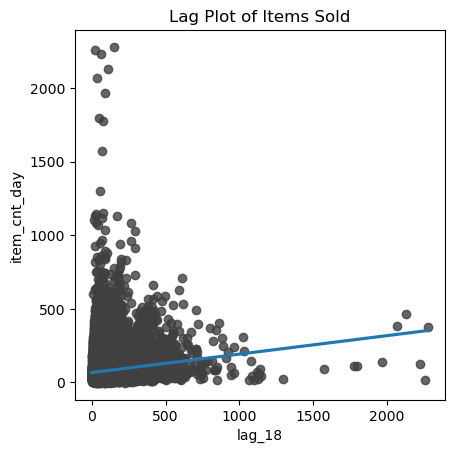

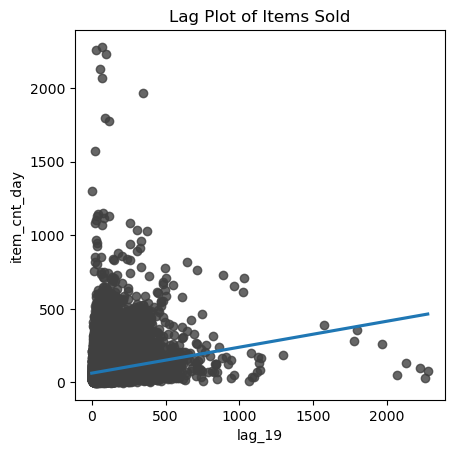

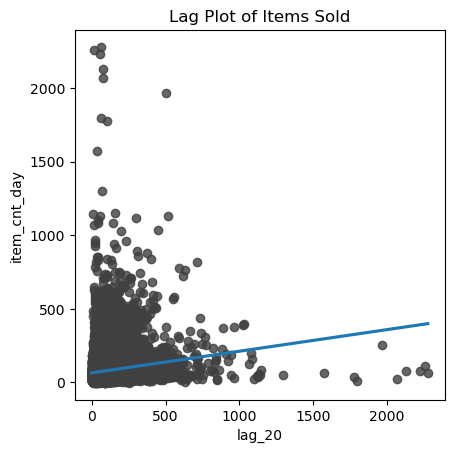

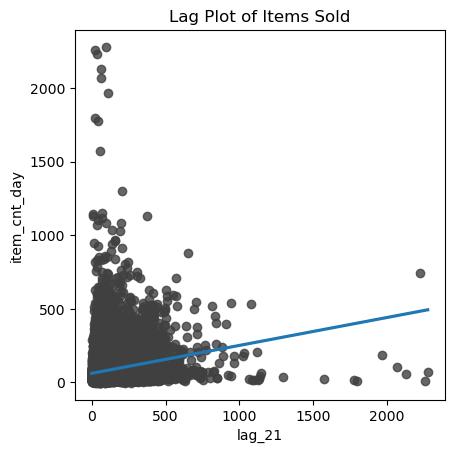

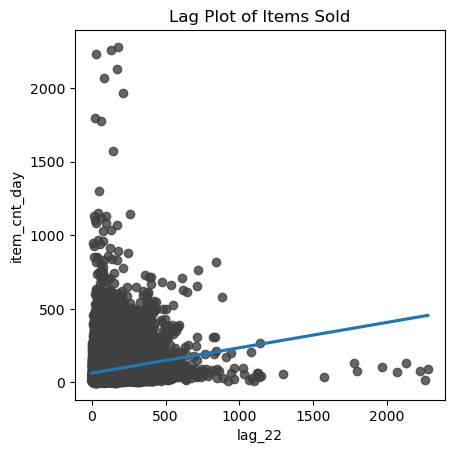

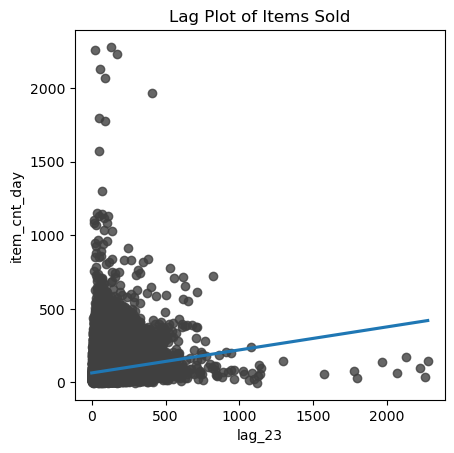

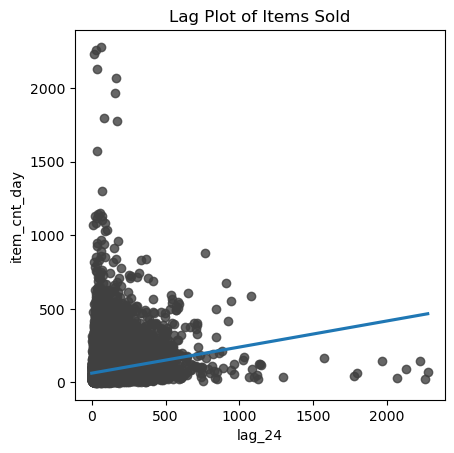

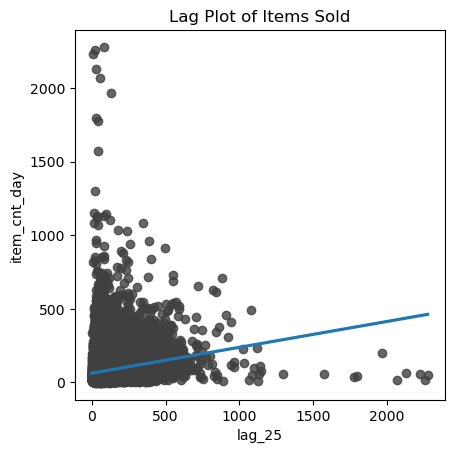

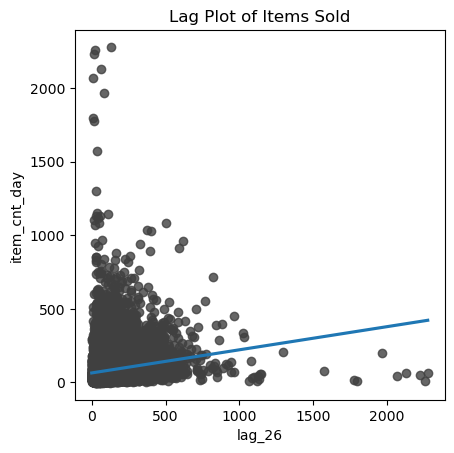

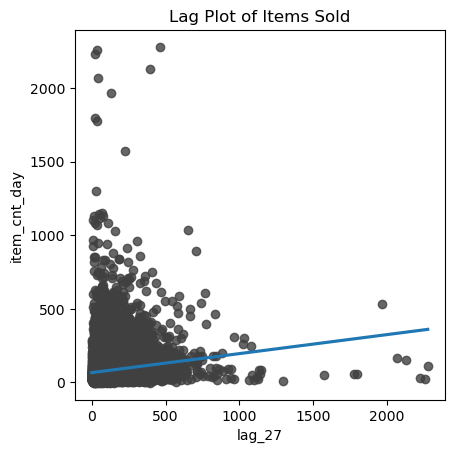

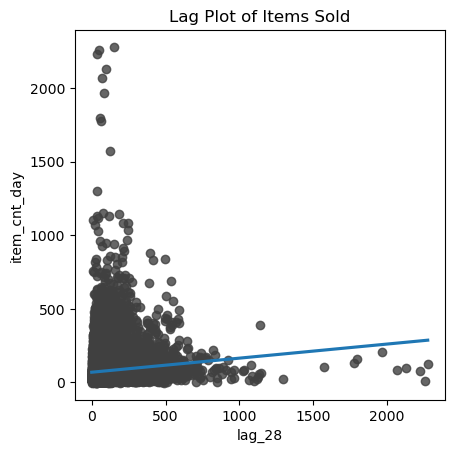

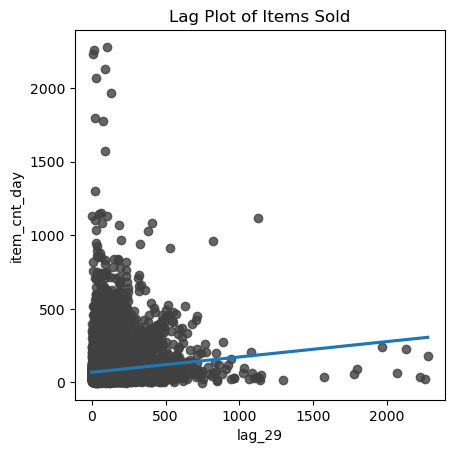

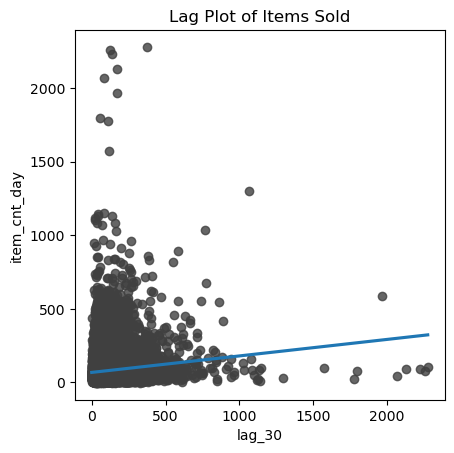

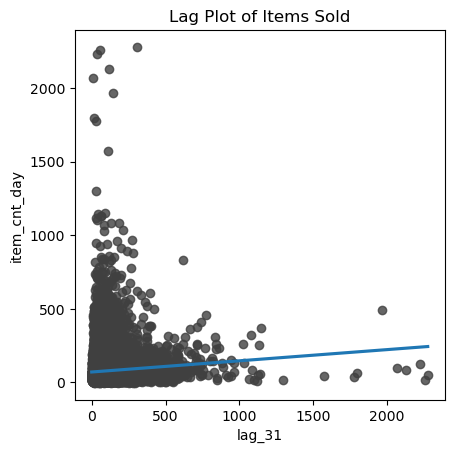

In [42]:
for i in range(31):
    fig, ax = plt.subplots()
    ax = sns.regplot(x=f'lag_{i+1}', y='item_cnt_day', data=sales_, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_aspect('equal')
    ax.set_title('Lag Plot of Items Sold');